**Tabla de contenido**

- [Introducción](#Introduccion)
- [Lectura de datos](#Lectura-de-datos)
- [Preparación del dataframe](#Preparacion-del-dataframe)
- [Análisis exploratorio de los datos](#Analisis-exploratorio-de-los-datos)
    - [Box Plot](#Box-Plot)
    - [Histogramas](#Histogramas)
    - [Respuestasa preguntas EDA](#Respuestas-a-preguntas-EDA)
        - [Feature engineering](#Feature-engineering)
        - [Análisis de sentimientos](#analisis-de-sentimientos)
    - [Resumen](#Resumen)
- [Modelado](#Modelado)

# Introduccion

En este cuaderno examinaremos la información disponible sobre las interacciones generadas por los videos con mayor tendencia en YouTube en USA. El objetivo es identificar las categorías dominantes, los atributos más relevantes y los factores clave que contribuyen a que un video se vuelva tendencia, así como analizar si la fecha de publicación influye significativamente en su popularidad.

Además, se entrenarán modelos predictivos para estimar la cantidad de “likes” o visitas que podría alcanzar un video. No siendo más, comensemos.

# Lectura de datos

In [1]:
import pandas as pd
import numpy as np
import re
import json
import os
file_path = lambda file: os.path.join(os.getcwd(),'data',file)


Empecemos leyendo el archivo `Json` que contiene las categorias de los videos. Para ello, lo haremos de la siguiente forma:

- `pd.json_normalize`: Esta función de pandas toma datos en formato `JSON`, incluso si son complejos y anidados, y los transforma en un DataFrame plano y estructurado, lo que facilita su manipulación y análisis. Sus parámetros principales son:
    - `data`: Es el objeto `Json` que contiene los datos a procesar.
    - `record_path`: Es la lista de interes. Cada elemento dentro de la lista, representa una fila en el dataframe.
    - `meta`: Con esto se indica la lista de columnas (claves) que quieres incluir y que existendo dentro de la lista de interes.

In [2]:
data = json.load(open('data/US_category_id.json'))
df_Category = pd.json_normalize(
    data=data,
    record_path='items',
)

df_Category = df_Category[["id", "snippet.channelId", "snippet.title", "snippet.assignable"]]
df_Category.columns = ["id", "channelId", "title", "assignable"]
df_Category.head()

,id,channelId,title,assignable
0,1,UCBR8-60-B28hp2BmDPdntcQ,Film & Animation,True
1,2,UCBR8-60-B28hp2BmDPdntcQ,Autos & Vehicles,True
2,10,UCBR8-60-B28hp2BmDPdntcQ,Music,True
3,15,UCBR8-60-B28hp2BmDPdntcQ,Pets & Animals,True
4,17,UCBR8-60-B28hp2BmDPdntcQ,Sports,True


Perfecto!. Ahora leamos los datos del archivo csv.

In [3]:
df_vid= pd.read_csv(file_path('USvideos.csv'))
df_vid.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


# Preparacion del dataframe

Dado que contamos con ambos DataFrames (df_vid y df_Category) correctamente leídos, es momento de organizar y ajustar los tipos de datos que contienen. En esta sección realizaremos lo siguiente:

- `Corrección del formato de fecha`: Convertiremos las fechas al tipo de dato datetime.
- `Ajuste de tipos de datos`: Verificaremos que cada columna posea el tipo de dato adecuado (number u object, según corresponda).
- `Merge`.

In [4]:
df_Category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          32 non-null     object
 1   channelId   32 non-null     object
 2   title       32 non-null     object
 3   assignable  32 non-null     bool  
dtypes: bool(1), object(3)
memory usage: 932.0+ bytes


In [5]:
df_Category['id']= df_Category['id'].astype('Int64')

Perfecto!. Cada columna contiene su respectivo tipo de dato. Veamos ahora el dataframe de los videos.

In [6]:
df_vid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

Aquí solo tenemos dos variables a las cuales se les necesita definir correctamente el formato, estas son:
- trending_date: Día en que el el video empezó a estar en tendencia.
- publish_time: Día en el que el video fue públicado.

In [7]:
df_vid['trending_date'] = pd.to_datetime(df_vid['trending_date'], format='%y.%d.%m')
df_vid['trending_date'] = df_vid['trending_date'] + pd.Timedelta(hours=23, minutes=59, seconds=59) # se asume que se hace tendencia al final del dia
df_vid['trending_date'] = df_vid['trending_date'].dt.tz_localize('America/New_York')

df_vid['publish_time'] = pd.to_datetime(df_vid['publish_time'],utc=True)
df_vid['publish_time'] = df_vid['publish_time'].dt.tz_convert('America/New_York')
df_vid.head(2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14 23:59:59-05:00,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 12:13:01-05:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14 23:59:59-05:00,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 02:30:00-05:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


Para finalizar esta sección, asignaremos la categoría correspondiente a cada video. Para ello, realizaremos un merge entre los dos DataFrames (df_vid y df_Category), utilizando como columnas clave category_id (en df_vid) e id (en df_Category).

In [8]:
df_vid = pd.merge(df_vid,df_Category,left_on='category_id',right_on='id', how='left')
df_vid.head(1)

,video_id,trending_date,title_x,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,id,channelId,title_y,assignable
0,2kyS6SvSYSE,2017-11-14 23:59:59-05:00,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 12:13:01-05:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,22,UCBR8-60-B28hp2BmDPdntcQ,People & Blogs,True


In [9]:
df_vid.rename(columns={'title_y': 'category'}, inplace=True)
df_vid = df_vid.drop(columns=['category_id','id'],axis=1)

Con esto ya estamos listos para explorar los datos.

# Analisis exploratorio de los datos

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Esto implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar cómo se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos, y finalmente extraer conclusiones a partir de este proceso.

En síntesis, el análisis exploratorio es una etapa clave para entender, visualizar y extraer información valiosa del dataset, lo que nos permite elegir con fundamento la estrategia o técnica más adecuada para su procesamiento posterior.

Este análisis exploratorio siempre inicia con las preguntas de investigación y es el paso cero antes de aplicar ciencia de datos. En este caso las preguntas son las siguientes:

`EDA`

1. ¿Cuáles son las categorías de vídeos que reciben mayores vistas y Likes?
2. ¿Es posible encontrar agrupaciones o clasificaciones de videos?
3. ¿Cuál es la combinación de características o atributos más importantes que hacen de un video tendencia?
4. ¿La temporada o fecha en el que el video es publicado tiene alguna influencia?
5. ¿Qué canales publican con mayor frecuencia y cuál es su promedio de likes y views?
6. ¿Cómo se distribuye la duración en tendencias para cada categoría?
7. ¿Existe relación entre la cantidad de comentarios y los likes recibidos?
8. ¿Qué etiquetas (tags) son más frecuentes y cómo influyen en views y likes?
9. ¿Cuál es la distribución temporal de las publicaciones (hora del día, día de la semana, mes)?
10. ¿Se observan picos de visualizaciones relacionados con eventos o fechas especiales (festivos, lanzamientos, etc.)?
11. ¿Cuántos videos fueron eliminados o presentaron errores y cómo afecta eso a las métricas?
12. ¿Cuál es el tiempo estimado desde la publicación hasta entrar en tendencias?

`Modelado`

1. ¿Es posible predecir la cantidad de likes que recibirá un video?
2. En caso afirmativo, ¿qué variables pueden utilizarse para realizar dichas predicciones?
3. ¿Qué técnica de predicción utilizar?

`Hipótesis`

- La fecha y la hora de publicación de un video influyen significativamente en la cantidad de likes que este recibirá.

Dicho esto, procedamos con la exploración de los datos.

In [10]:
print(f"la cantidad de resgistros que tiene el dataframe son: {df_vid.shape[0]}")
print(f"La cantidad de características son: {df_vid.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 40949
La cantidad de características son: 18


In [11]:
val_nan = {col:df_vid[col].isnull().sum() for col in df_vid.columns}
val_nan = pd.DataFrame.from_dict(val_nan, orient='index',columns=['nulos'])
val_nan.head(len(val_nan))

,nulos
video_id,0
trending_date,0
title_x,0
channel_title,0
publish_time,0
tags,0
views,0
likes,0
dislikes,0
comment_count,0


Podemos observar que el DataFrame cuenta con un total de `18 características` y `40949 registros`, de los cuales únicamente la columna `description presenta 570 registros sin descripción`.
Dado que me interesa conservar todo el conjunto de datos, asignaré la frase `"No description"` a aquellos registros que carecen de descripción, es decir, reemplazaré los valores NaN en esa columna por dicha frase. 

Además, crearé una nueva columna indicadora que tome el valor 1 para los videos con descripción y 0 para aquellos que no la tienen.

In [12]:
df_vid['con_descripcion'] = df_vid['description'].isnull().map({False:1,True:0})
df_vid['description'] = df_vid['description'].fillna('No description')

Ahora veamos si hay registros dúplicados.

In [13]:
total_duplicados = df_vid.duplicated().sum()
print(f"Duplicados (sin contar la primera aparición): {total_duplicados}")

Duplicados (sin contar la primera aparición): 48


In [14]:
df_vid = df_vid.drop_duplicates() # Elimina duplicados conservando la primera aparición

## Box Plot

In [15]:
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.express as px

def plot_boxplots(df, title='Boxplots por variable', height=300):
    """
    Genera un boxplot interactivo con colores variados para cada columna numérica del DataFrame.

    Parámetros:
    - df: pandas.DataFrame con los datos
    - title: título del gráfico
    - height: altura del gráfico en píxeles
    """
    fig = go.Figure()

    numeric_cols = df.select_dtypes(include='number').columns
    colors = pc.qualitative.Plotly  # paleta de colores categóricos

    for i, column in enumerate(numeric_cols):
        fig.add_trace(go.Box(
            y=df[column],
            name=column,
            boxpoints='outliers',
            marker=dict(size=4, color=colors[i % len(colors)]),
            line=dict(color=colors[i % len(colors)]),
            fillcolor=colors[i % len(colors)],
        ))

    fig.update_layout(
        title=title,
        yaxis_title='Valor',
        #boxmode='group',
        template='plotly_white',
        font=dict(family='Arial', size=14),
        margin=dict(l=40, r=40, t=60, b=80),
        height=height,
        showlegend=False,
        autosize=True,
    )

    fig.show()
df_vid.columns = df_vid.columns.str.strip()
plot_boxplots(df_vid, title='Distribución de variables numéricas', height=300)

# Histogramas

In [16]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_histograms_grid(df, exclude_cols=['Date'], bins=None, title="Distribuciones"):
    """
    Genera un grid de histogramas para cada columna numérica del DataFrame,
    excluyendo las columnas especificadas en `exclude_cols`.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada.
        exclude_cols (list): Columnas a excluir (por defecto ['Date']).
        bins (int): Número de bins para los histogramas. Si es None, se calcula automáticamente.
        title (str): Título general de la figura.
    
    Retorna:
        fig (go.Figure): Figura con los subplots.
    """
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns        # Filtrar columnas numéricas y excluir las no deseadas
    cols_to_plot = numeric_cols.difference(exclude_cols)
    n = len(cols_to_plot)
    
    if n == 0:
        raise ValueError("No hay columnas numéricas para graficar.")
    
    
    if bins is None:                                                    # Calcular bins si no se especifica
        bins = int(2 * len(df)**(1/3))                                  # Regla de Sturges modificada
    
    cols_grid = min(3, n)                                               # Configuración del grid (máximo 4 columnas para mejor visualización)
    rows_grid = int(np.ceil(n / cols_grid))
    
    # Plantilla profesional
    professional_template = {
        'layout': go.Layout(
            font=dict(family="Arial", size=12, color="#333"),
            title=dict(font=dict(size=16, color="#333"), x=0.5, xanchor='center'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            margin=dict(l=40, r=40, t=60, b=40),
            hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
        )
    }
    
    # Crear figura con subplots
    fig = sp.make_subplots(
        rows=rows_grid,
        cols=cols_grid,
        subplot_titles=cols_to_plot,                                       # Pone los títulos a cada histograma
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )
    
    # Añadir histogramas
    for i, col in enumerate(cols_to_plot, 1):
        row = ((i - 1) // cols_grid) + 1
        col_pos = ((i - 1) % cols_grid) + 1
        
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=bins,
                marker=dict(
                    color='rgba(100, 149, 237, 0.7)',
                    line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
                ),
                opacity=0.9,
                hovertemplate=f"{col}: %{{x}}<br>Frecuencia: %{{y}}<extra></extra>",
                name=col
            ),
            row=row, col=col_pos
        )
        
        # Personalizar ejes
        fig.update_xaxes(
            #title_text=col,                                # pone títulos a eje x
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
        fig.update_yaxes(
            title_text="Frecuencia",
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
    
    # Actualizar layout general
    fig.update_layout(
        height=300 * rows_grid,
        width=400 * min(cols_grid, 3),  # Evitar que sea demasiado ancho
        showlegend=False,
        template=professional_template,
        title_text=title,
        title_x=0.5
    )
    
    return fig

fig = plot_histograms_grid(df_vid, title="Distribuciones de variables numéricas")
fig.show()

In [17]:
for col in df_vid.select_dtypes(include=['number']).columns:
    print(f"Columna:{col}, Skewness:{df_vid[col].skew():.6f}")

Columna:views, Skewness:12.236429
Columna:likes, Skewness:10.919968
Columna:dislikes, Skewness:40.167724
Columna:comment_count, Skewness:19.744500
Columna:con_descripcion, Skewness:-8.300687


Podemos observar lo siguiente:

- `Boxplot`: Los datos muestran diferentes escalas, destacándose especialmente la variable view, que presenta la amplitud más amplia. Esto sugiere dos posibles acciones: analizar en detalle los valores atípicos o aplicar una transformación de escala, como el uso de un RobustScaler, para mitigar su efecto.
- `Histogramas`: La mayoria de las variables presentan mayor concentración de valores cercacons a los cero millones, con una disminución progresiva hacia valores mayores. Esto indica que las características `views`, `likes`, `dislikes` y `comment_count` presentan una distribución sesgada positivamente, con una cola extendida hacia la derecha, tal como se confirma en las medidas de asimetría (skewness) reportadas.

# Respuestasa preguntas EDA

Ahora que hemos comprendido la estructura y características de los datos, es momento de abordar las preguntas de investigación planteadas para este análisis exploratorio.

In [18]:
# Categorías de video con más vistas y likes
top_categories_views_likes = df_vid.groupby(by=['category']).agg(
    suma_likes = ('likes','sum'),
    suma_views = ('views','sum'),
    mean_likes = ('likes','mean'),
    mean_views = ('views','mean')
).reset_index()

In [19]:
def crear_barplot_personalizado(df, x, y, color,decimales ,titulo=''):
    """
    Crea un gráfico de barras personalizado usando Plotly.

    Parámetros:
    - df: DataFrame de entrada
    - x: columna para el eje X
    - y: columna para el eje Y
    - color: columna para agrupar por color
    - titulo: título opcional del gráfico
    """
    bar_fig = px.bar(
        df,
        x=x,
        y=y,
        color=color,
        barmode='group',
        text=y,
        labels={x: 'Categoría del producto', y: 'Cantidad'},
    )

    # Personalización del gráfico
    bar_fig.update_traces(textposition='outside',texttemplate=decimales,
                          textfont=dict(family='Arial', size=12, color='black', weight='bold'))
    bar_fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=18, family='Arial', color='black'),

        xaxis=dict(
            title_font=dict(size=12, family='Arial', color='black'),
            tickfont=dict(size=7, family='Arial', color='black', weight='bold'),
            showgrid=True,
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='black', weight='bold'),
            autorange=True,
            ticklen=10,
            showline=True,
            linecolor='black',
            automargin=True,
            ticksuffix='   ',
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial'
        ),
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.05,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        bargap=0.2,
    )

    return bar_fig

In [20]:
top_categories_views_likes = top_categories_views_likes.sort_values(
    by='suma_likes',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 

fig = crear_barplot_personalizado(top_categories_views_likes, 
                                  x='category', 
                                  y='suma_views', 
                                  color='suma_likes',
                                  decimales ='%{y:.0f}',
                                  titulo='Ranking de categorías con mayor interacción: vistas y likes')
fig.show()

Podemos observar que las categorías con más vistas y likes son:
- Music 
- Entertainment
- Film & Animation

Veamos ahora, cuantos videos hay en cada categoría.

In [21]:
videos_per_category = df_vid['category'].value_counts().reset_index()
videos_per_category.columns =['category', 'total_videos']
videos_per_category['Porcentaje'] = (videos_per_category['total_videos']/videos_per_category['total_videos'].sum())*100
fig = crear_barplot_personalizado(videos_per_category, 
                                  x='category', 
                                  y='Porcentaje', 
                                  color='total_videos',
                                  decimales ='%{y:.1f}',
                                  titulo='Porcentaje de videos por categoría')
fig.show()

Podemos observar lo siguiente:

- Entertainment: Es la categoría con mayor porcentaje de videos (24.3%).
- Music: Es la segunda categoría con mayor porcentaje de videos (15.8%).
- Howto & Style: Es la tercer categoría con mayor porcentaje de videos (10.1)

Veamos ahora, cuanto tarda un video en ser tendencia en cada una de estás categorias.

In [22]:
df_vid['days_to_trend'] =  df_vid['trending_date']- df_vid['publish_time']
df_vid['days_to_trend'] = df_vid['days_to_trend'].dt.total_seconds()/86400

time_to_tren = df_vid.groupby(by=['category']).agg(
    max_days = ('days_to_trend','max'),
    min_days =('days_to_trend','min'),
    mean_days =('days_to_trend','mean')
).reset_index()
time_to_tren = time_to_tren.sort_values(
    by='max_days',
    ascending=True
)
fig = crear_barplot_personalizado(time_to_tren, 
                                  x='category', 
                                  y='max_days', 
                                  color='mean_days',
                                  decimales ='%{y:.1f}',
                                  titulo='Tiempo máximo y promedio hasta que un video entra en tendencia según su categoría')
fig.show()

In [23]:
time_to_tren = time_to_tren.sort_values(
    by='min_days',
    ascending=True
)
fig = crear_barplot_personalizado(time_to_tren, 
                                  x='category', 
                                  y='min_days', 
                                  color='mean_days',
                                  decimales ='%{y:.2f}',
                                  titulo='Tiempo mínimo y promedio hasta que un video entra en tendencia según su categoría')
fig.show()

In [24]:
time_to_tren = time_to_tren.sort_values(
    by='mean_days',
    ascending=True
)
fig = crear_barplot_personalizado(time_to_tren, 
                                  x='category', 
                                  y='mean_days', 
                                  color='mean_days',
                                  decimales ='%{y:.2f}',
                                  titulo='Tiempo promedio hasta que un video entra en tendencia según su categoría')
fig.show()

Podemos observar lo siguiente:

- Tiempo máximo en llegar a ser tendencia: Considerando el tiempo máximo registrado para cada categoría, aquellas que alcanzan la tendencia en menor tiempo son:
    - Nonprofits & Activism: Máximo de 14.6 días para llegar a tendencia, con un promedio de 6 días.
    - Shows: Máximo de 27.3 días, con un promedio de 11 días.
    - Travel & Eventes: Máximo de 60 días, con un promedio de 8 días.
- Tiempo mínimo en llegar a ser tendencia: Considerando el tiempo mínimo registrado para cada categoria, aquellas que alcanzan la tendencia en menor tiempo son:
    - Science & Tecnology: Mínimo de 0.67 días, con un promedio de 19 días.
    - Music: Mínimo de 0.84 días, con un promedio de 15 días.
    - Entertainment: Mínimo de 0.95 días, con un promedio de 14 días.

Estos resultados indican que el número total de videos publicados en una categoría no es un factor determinante para que un video alcance la tendencia. Sin embargo, las interacciones (vistas, likes) parecen influir significativamente en reducir el tiempo mínimo necesario para que un video se posicione como tendencia.

Pero, `¿será esto verdad?`. ¿Qué factores determinan que un video entre en tendencia en un largo o corto plazo?

### Feature engineering

Para responder a la pregunta anterior, es necesario incorporar nuevas variables al dataset. En este caso, añadiremos la fecha como variable predictora (sin transformarla mediante funciones seno o coseno), codificaremos ciertas variables como dummies y calcularemos una matriz de correlación. Esto nos permitirá identificar posibles relaciones entre las variables.

In [25]:
import holidays
df_vid['day'] = df_vid['publish_time'].dt.day
df_vid['month'] = df_vid['publish_time'].dt.month
df_vid['Year'] = df_vid['publish_time'].dt.year
df_vid['hour'] = df_vid['publish_time'].dt.hour
df_vid['week_day'] = df_vid['publish_time'].dt.isocalendar().day # lunes =1
df_vid['week'] = df_vid['publish_time'].dt.isocalendar().week

# agreguemos los días festivos oficiales de US
us_holidays = holidays.US()
df_vid['is_holiday'] = df_vid['publish_time'].isin(us_holidays)

In [26]:
col_bool = df_vid.select_dtypes(include=['bool']).columns.tolist()
df_vid[col_bool] = df_vid[col_bool].astype(int)

Ahora solo falta codificar las variables categóricas a dummy.

In [27]:
print(f"columnas categóricas: {df_vid.select_dtypes(include=['object']).columns}")

columnas categóricas: Index(['video_id', 'title_x', 'channel_title', 'tags', 'thumbnail_link',
       'description', 'channelId', 'category'],
      dtype='object')


Codificaremos la variable de categoría, añadiremos la longitud del título y de la descripción, y analizaremos si existen correlaciones entre las variables.

In [28]:
print(df_vid['category'].unique())

['People & Blogs' 'Entertainment' 'Comedy' 'Science & Technology'
 'Film & Animation' 'News & Politics' 'Sports' 'Music' 'Pets & Animals'
 'Education' 'Howto & Style' 'Autos & Vehicles' 'Travel & Events' 'Gaming'
 'Nonprofits & Activism' 'Shows']


In [29]:
dummies = pd.get_dummies(df_vid['category'], dtype='int8')
df = pd.concat([df_vid,dummies],axis=1)

df['len_title'] = df_vid['title_x'].str.len()
df['len_description'] = df_vid['description'].str.len()

### Analisis de sentimientos

Dado que ya tenemos la mayoria de las variables codificadas, es momento de analizar el sentimiento que transmite el titulo del video y la descripción. Esto con el propósito de ver si influyen en que un video se haga tendencia. Para esto utilizaremos el modelo `GoEmotions`.

GoEmotions es un modelo de aprendizaje automático basado en BERT (arquitectura transformer), diseñado para detectar y clasificar emociones en texto. Fue desarrollado por Google Research y entrenado con 58,000 comentarios de Reddit etiquetados manualmente, cubriendo:

- 27 categorías emocionales (ej. admiración, enojo, diversión, gratitud, nostalgia).
- Idioma: Entrenado en inglés.

La aplicación de este modelo implica limpiar lo titulos y las descripciones de emoticones, caracteres raros, URL, etc.

In [30]:
from urlextract import URLExtract
import emoji

def cleantext_toGoEmotions(text):
    """
    Limpieza para GoEmotions:
    1. Conserva tokens especiales: [URL], [EMAIL], [PHONE], [USER].
    2. Elimina emoticonos (😊, :D, etc.) y convierte emojis a texto opcional.
    3. Mantiene puntuación clave (!, ?, .) para contexto emocional.
    """
    # Normalizar espacios
    text = re.sub(r"\s+", " ", text).strip()
    email_pattern = r'\b([A-Za-z0-9._%+-]+)\s*(?:@|\[at\]|\(at\)|arroba)\s*([A-Za-z0-9.-]+)\s*(?:\.|\[dot\]|\(dot\)|punto)\s*([A-Za-z]{2,})\b'
    text = re.sub(email_pattern,'[EMAIL]',text)                 # reemplaza correo electrónicos a [EMAIL]
    # Reemplazo de URLs estándar detectadas por URLExtract
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, '[URL]')  
    # Patrón “raro” en url (/p/... .xxx)
    pattern_url_raro =  r"/[A-Za-z]/[\w-]+\.[A-Za-z]{2,4}\b"
    text = re.sub(pattern_url_raro, "[URL]", text)
    # Cualquier HTTP/HTTPS
    pattern_any_url = r"(?:https?://|://)[^\s]+"
    text = re.sub(pattern_any_url, "[URL]", text)
    # patrones raros
    pattern_scheme = r"\b[a-z][\w+.-]*://[^\s]+\b"
    text = re.sub(pattern_scheme, "[URL]", text)
    text = re.sub(r"@\w+", " [USER] ", text)                    # reemplaza usuarios por [USER]

    # Eliminar emoticonos (como :D, :P, :-)) 
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P|/)', '', text)
    
    # Convertir emojis a texto y luego eliminarlos 
    text = emoji.demojize(text)  
    text = re.sub(r':[a-zA-Z_]+:', '', text)
    text = re.sub(r'//+', '', text)
    text = re.sub(r'!!+', '!', text)  
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'\-{2,}', '-', text)
    text = re.sub(r'\_{2,}', ' ', text)
    text = re.sub(r'\*{2,}', '', text)
    simbolos_raros = r'[❐❏➫�★☆⚡�☀☁☂☃☄☎☑☒☢☣☤☥☮☯☸☹☺♩♪♫♬♺♻♼♽⟁⟂⟤⟥⧉⧊⧋⧌⧍⧎⧏⧐⧑⧒⧓⧔⧕⧖⧗»♡⟡▲▼→►•]'
    text = re.sub(simbolos_raros, '', text).strip()
    text = re.sub(r'\n+-?\n*', '', text).strip()
    text = re.sub(r'[\n➢~]', ' ', text)
    text = re.sub(r'[\n-]+$', ' ', text)
    text =re.sub(r'(\[URL\]\s*)+', '[URL]', text)
    text = text.lower()
    text = re.sub(r"\s+"," ", text).strip()
    return text

In [31]:
pd.set_option('display.max_colwidth', None)  # Mostrar todo el contenido de las celdas
muestra = df_vid['title_x'].sample(n=10)
muestra.head(10)

15256    I Dyed My Virgin Hair For The First Time | Beauty With Mi | Refinery29
3902                        Everything Wrong With Arrival In 16 Minutes Or Less
38577                   Blind Girl Describes My Face to a Police Sketch Artist!
39508          Official Call of Duty®: Black Ops 4 — Multiplayer Reveal Trailer
22341                           MONEY Explained by Non-Experts | Thomas Sanders
14960                                        China BANS Hip Hop From Television
14208                               Are Taco Bell's Nacho Fries Worth the Hype?
40132               Destination Wedding Trailer #1 (2018) | Movieclips Trailers
35448                                                        When Trees Go Nuts
27430                                              MØ - Nostalgia (Lyric Video)
Name: title_x, dtype: object

In [32]:
muestra = muestra.apply(cleantext_toGoEmotions)
muestra.head(10)

15256    i dyed my virgin hair for the first time | beauty with mi | refinery29
3902                        everything wrong with arrival in 16 minutes or less
38577                   blind girl describes my face to a police sketch artist!
39508           official call of duty: black ops 4 — multiplayer reveal trailer
22341                           money explained by non-experts | thomas sanders
14960                                        china bans hip hop from television
14208                               are taco bell's nacho fries worth the hype?
40132               destination wedding trailer #1 (2018) | movieclips trailers
35448                                                        when trees go nuts
27430                                              mø - nostalgia (lyric video)
Name: title_x, dtype: object

Vale, ahora apliquemos esta función a los titulos.

In [33]:
df['title_x'] = df['title_x'].apply(cleantext_toGoEmotions)

Ok. Obtengamos los sentimientos que transmiten los titulos de los videos.

In [34]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="joeddav/distilbert-base-uncased-go-emotions-student",
    top_k=None,  
    device=0,    
    batch_size=32 
)
texts = df['title_x'].astype(str).tolist()
results = classifier(texts)
df['title_sentiment'] = [max(res, key=lambda x: x['score'])['label'] for res in results]


Device set to use cuda:0


In [35]:
df['title_sentiment'].unique()

array(['desire', 'excitement', 'anger', 'curiosity', 'caring', 'surprise',
       'amusement', 'realization', 'approval', 'confusion', 'fear',
       'nervousness', 'annoyance', 'gratitude', 'love', 'disapproval',
       'sadness', 'disappointment', 'pride', 'joy', 'embarrassment',
       'relief', 'admiration', 'grief', 'remorse', 'disgust', 'optimism',
       'neutral'], dtype=object)

Ahora que ya tenemos los sentimiento transmitidos por los titulos de los vidos, procedemos a reducirlos a solo 9 sentimientos. Esta reducción está inspirada en la Rueda de las emociones de Robert Plutchik, un modelo ampliamente citado en psicología emocional. Plutchik propone que existen ocho emociones básicas (alegría, confianza, miedo, sorpresa, tristeza, aversión, ira y anticipación) que se combinan para formar emociones más complejas.

Por lo tanto, en lugar de trabajar con una lista extensa de emociones muy específicas, es válido agruparlas en 8 categorías compuestas que mantienen el sentido emocional original:

- Optimismo (alegría + anticipación)

- Amor (alegría + confianza)

- Sumisión (confianza + miedo)

- Susto (miedo + sorpresa)

- Decepción (sorpresa + tristeza)

- Remordimiento (tristeza + aversión)

- Desprecio (aversión + ira)

- Alevosía (ira + anticipación)

A estas 8 se añadió Neutral como novena categoría, para representar la ausencia de una emoción predominante.

In [37]:
emotion_mapping = {
    'desire': 'alevosía',
    'excitement': 'optimismo',
    'anger': 'alevosía',
    'curiosity': 'alevosía',
    'caring': 'amor',
    'surprise': 'susto',
    'amusement': 'optimismo',
    'realization': 'decepción',
    'approval': 'sumisión',
    'confusion': 'susto',
    'fear': 'susto',
    'nervousness': 'sumisión',
    'annoyance': 'alevosía',
    'gratitude': 'amor',
    'love': 'amor',
    'disapproval': 'desprecio',
    'sadness': 'remordimiento',
    'disappointment': 'decepción',
    'pride': 'optimismo',
    'joy': 'optimismo',
    'embarrassment': 'susto',
    'relief': 'sumisión',
    'admiration': 'amor',
    'grief': 'remordimiento',
    'remorse': 'remordimiento',
    'disgust': 'desprecio',
    'optimism': 'optimismo',
    'neutral': 'neutral'
}
df['title_sentiment']= df['title_sentiment'].map(emotion_mapping)
df['title_sentiment'].isnull().sum()

np.int64(0)

Veamos ahora, ¿qué sentimientos expresados en los títulos predominan en las categorías de los videos?

In [41]:
categ_sentim = df.groupby(by=['category','title_sentiment']).size().reset_index(name='Cantidad')

categ_sentim['Porcentaje'] = (categ_sentim['Cantidad']/categ_sentim['Cantidad'].sum())*100
categ_sentim = categ_sentim.sort_values(
    by='Cantidad',
    ascending=False
)

fig = crear_barplot_personalizado(categ_sentim, 
                                  x='category', 
                                  y='Porcentaje', 
                                  color='title_sentiment',
                                  decimales ='%{y:.2f}',
                                  titulo='')
fig.show()

Influyen los sentimientos transmitidos por los títulos de los videos en el tiempo que tarda un video en volverse tendencia?

In [46]:
mean_days_to_trend = df.groupby(by=['title_sentiment']).agg(
    mean_days =('days_to_trend','mean')
).reset_index()
mean_days_to_trend = mean_days_to_trend.sort_values(
    by='mean_days',
    ascending=False
)
fig = crear_barplot_personalizado(mean_days_to_trend, 
                                  x='title_sentiment', 
                                  y='mean_days', 
                                  color='mean_days',
                                  decimales ='%{y:.2f}',
                                  titulo='')
fig.show()

Podemos observar lo siguiente:

- Sentimientos predominantes en las categorías de los videos:
    - Optimismo: Entertainment, Music, Howto & Style, Sport, Film & Animation, Comedy, Gaming, Pets & Animals, Auto & Vehicles, Travel & Events.
    - Alevosía: Entertainment, Music, Howto & Style, Sport, Film & Animation, People & Blogs, Science & Tecnology, News & Politics, Education.
    - Desepción: Entertainment, Comedy, People & Blogs, News & Politics, Edcation.
    - Amor: Music, Entertainment.

- Sentimientos predominantes según el tiempo que tarda un video en volverse tendencia:
    - Sumisión: Los títulos que expresan sentimientos de sumisión tardan, en promedio, 8 días en convertirse en tendencia.
    - Neutral:  Los títulos que expresan sentimientos neutrales tardan, en promedio, 9 días en convertirse en tendencia.
    - Desprecio: Los títulos que expresan sentimientos de desprecio tardan, en promedio, 10 días en convertirse en tendencia.

Pero, ¿esto tendrá una realción directa?, veamos las correlaciones lineales y no lineales.

In [47]:
dummies_sentim = pd.get_dummies(df['title_sentiment'], dtype='int8')
df = pd.concat([df,dummies_sentim ],axis=1)

In [53]:
df.select_dtypes(include=['number']).head()

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,assignable,con_descripcion,days_to_trend,...,len_description,alevosía,amor,decepción,desprecio,neutral,optimismo,remordimiento,sumisión,susto
0,748374,57527,2966,15954,0,0,0,1,1,1.490949,...,1410,1,0,0,0,0,0,0,0,0
1,2418783,97185,6146,12703,0,0,0,1,1,1.895822,...,630,0,0,0,0,0,1,0,0,0
2,3191434,146033,5339,8181,0,0,0,1,1,2.412905,...,1177,1,0,0,0,0,0,0,0,0
3,343168,10172,666,2146,0,0,0,1,1,1.749942,...,1403,1,0,0,0,0,0,0,0,0
4,2095731,132235,1989,17518,0,0,0,1,1,2.457153,...,636,1,0,0,0,0,0,0,0,0


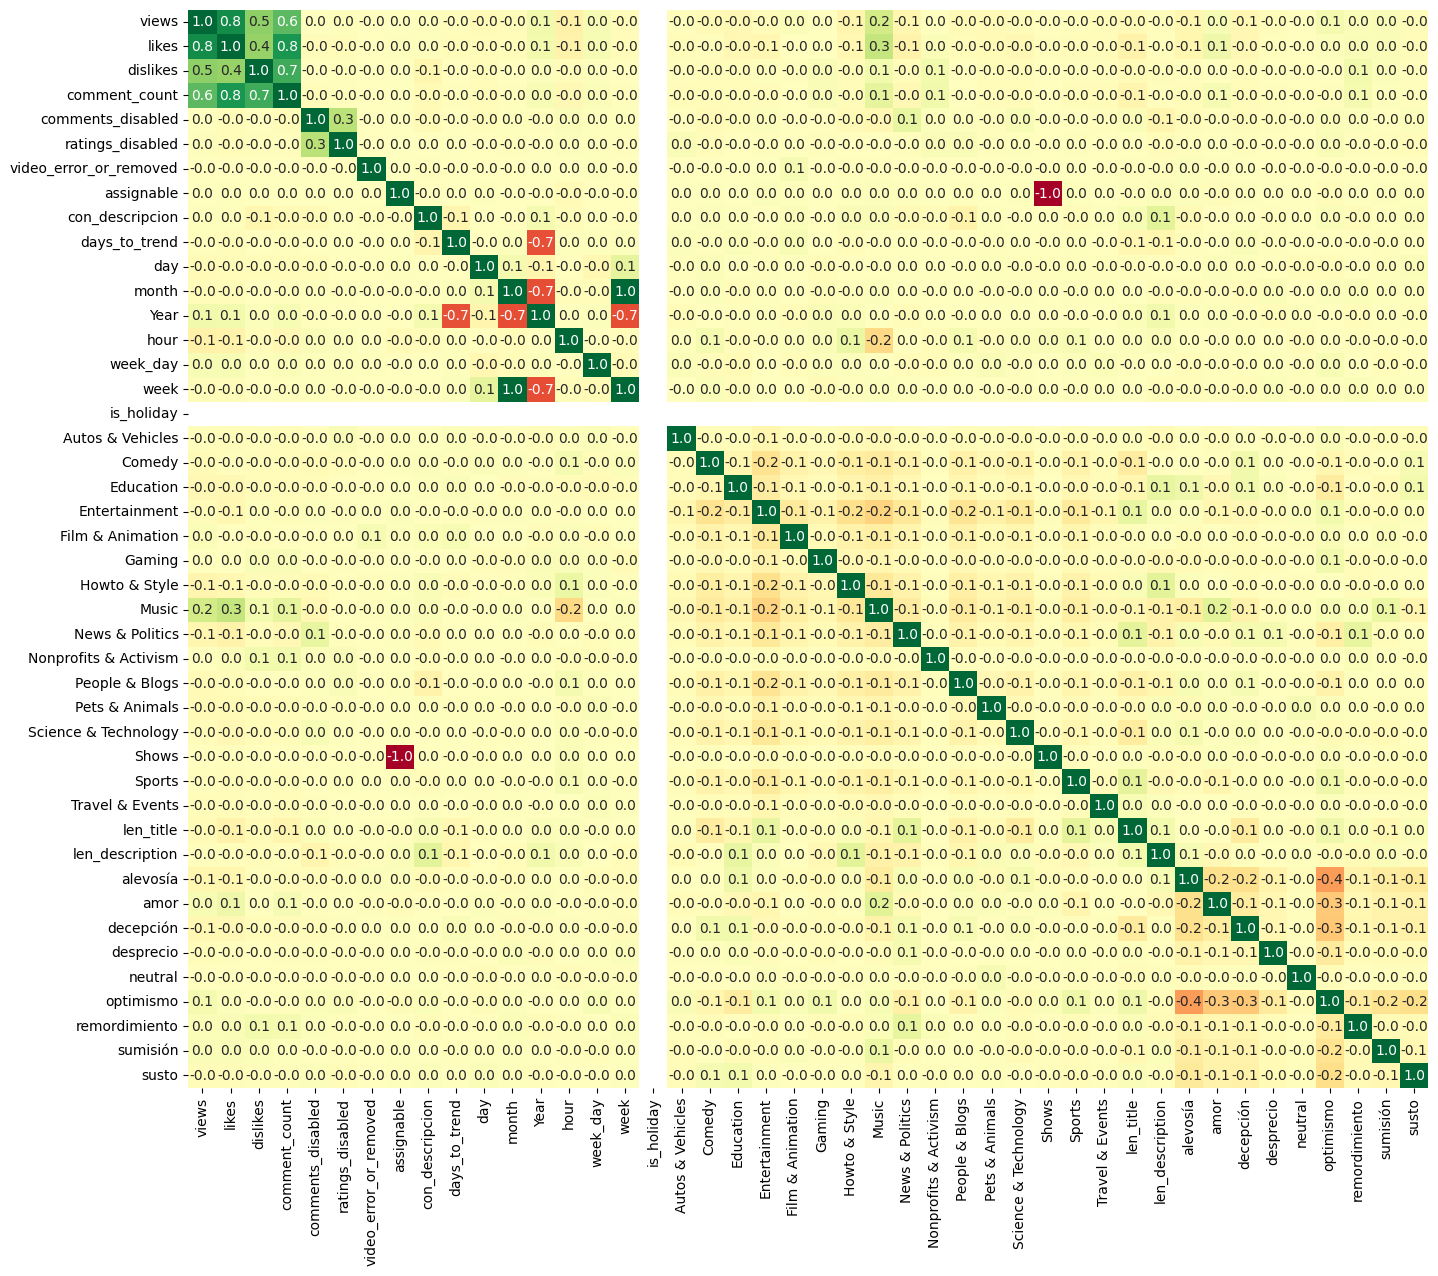

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 14))  
sns.heatmap(
    df.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=False 
)
plt.show()


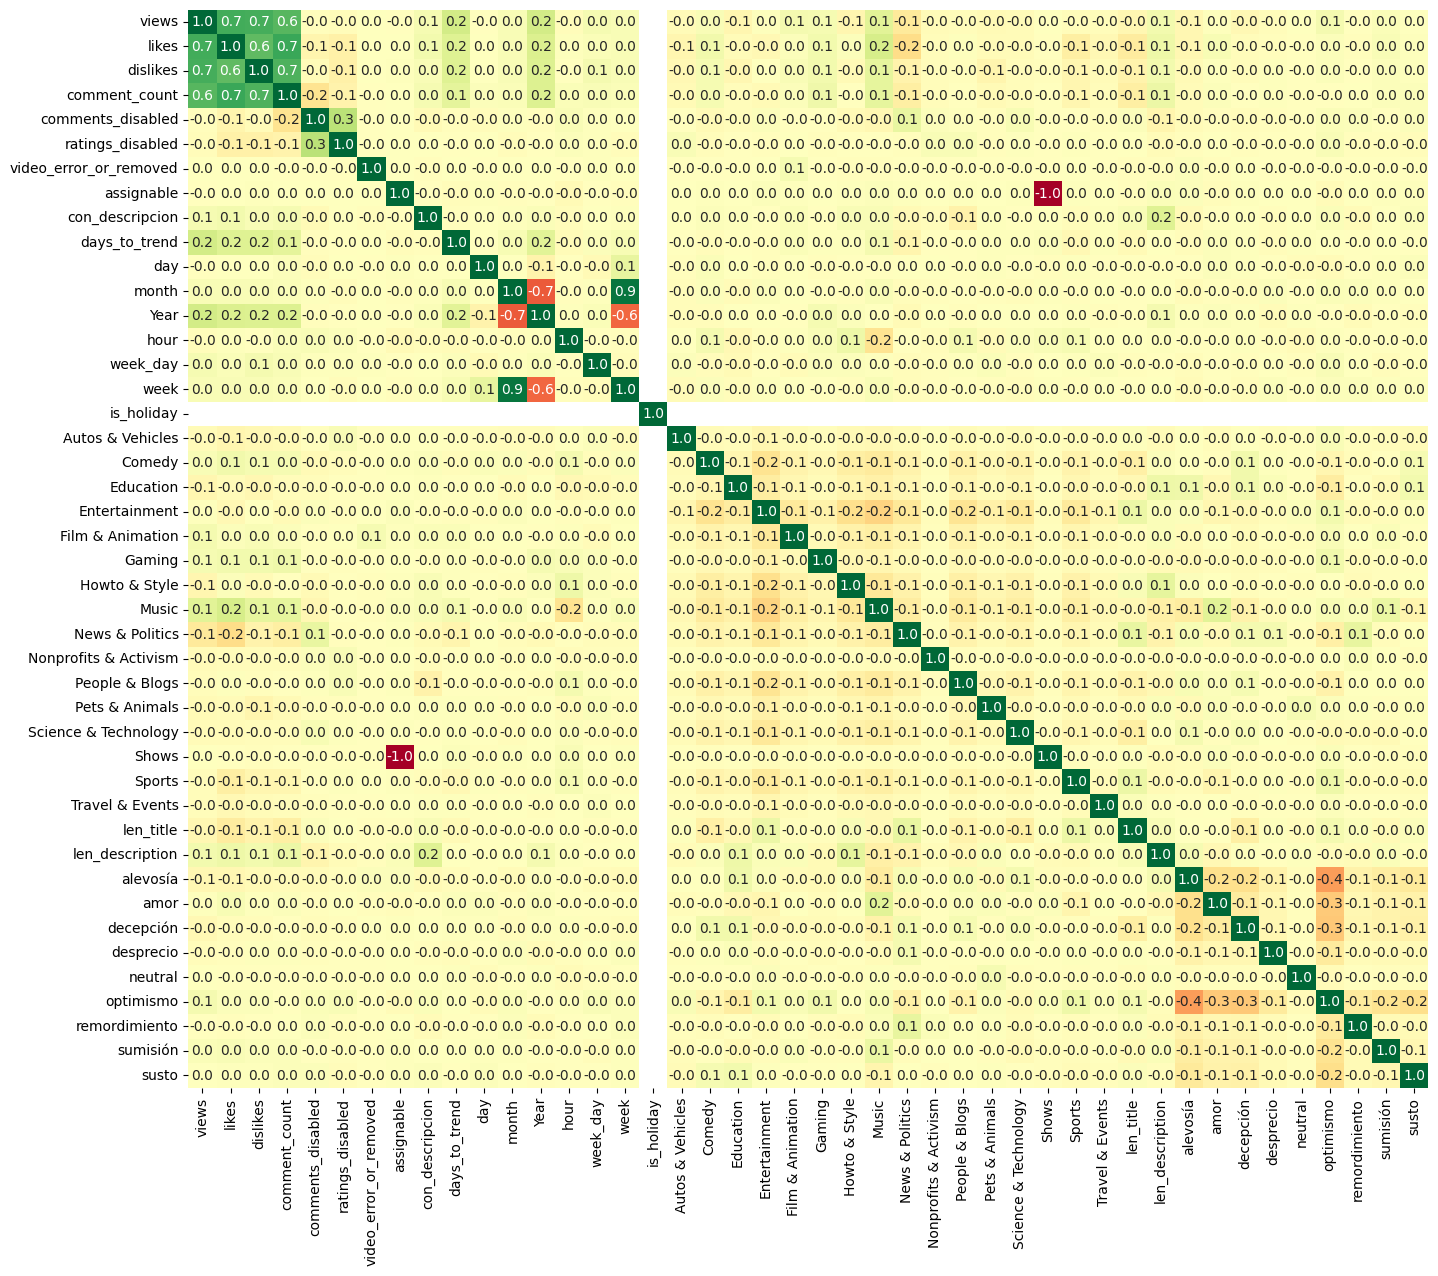

In [58]:
plt.figure(figsize=(16, 14))  
sns.heatmap(
    df.select_dtypes(include=['number']).corr(method='kendall'),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=False 
)
plt.show()

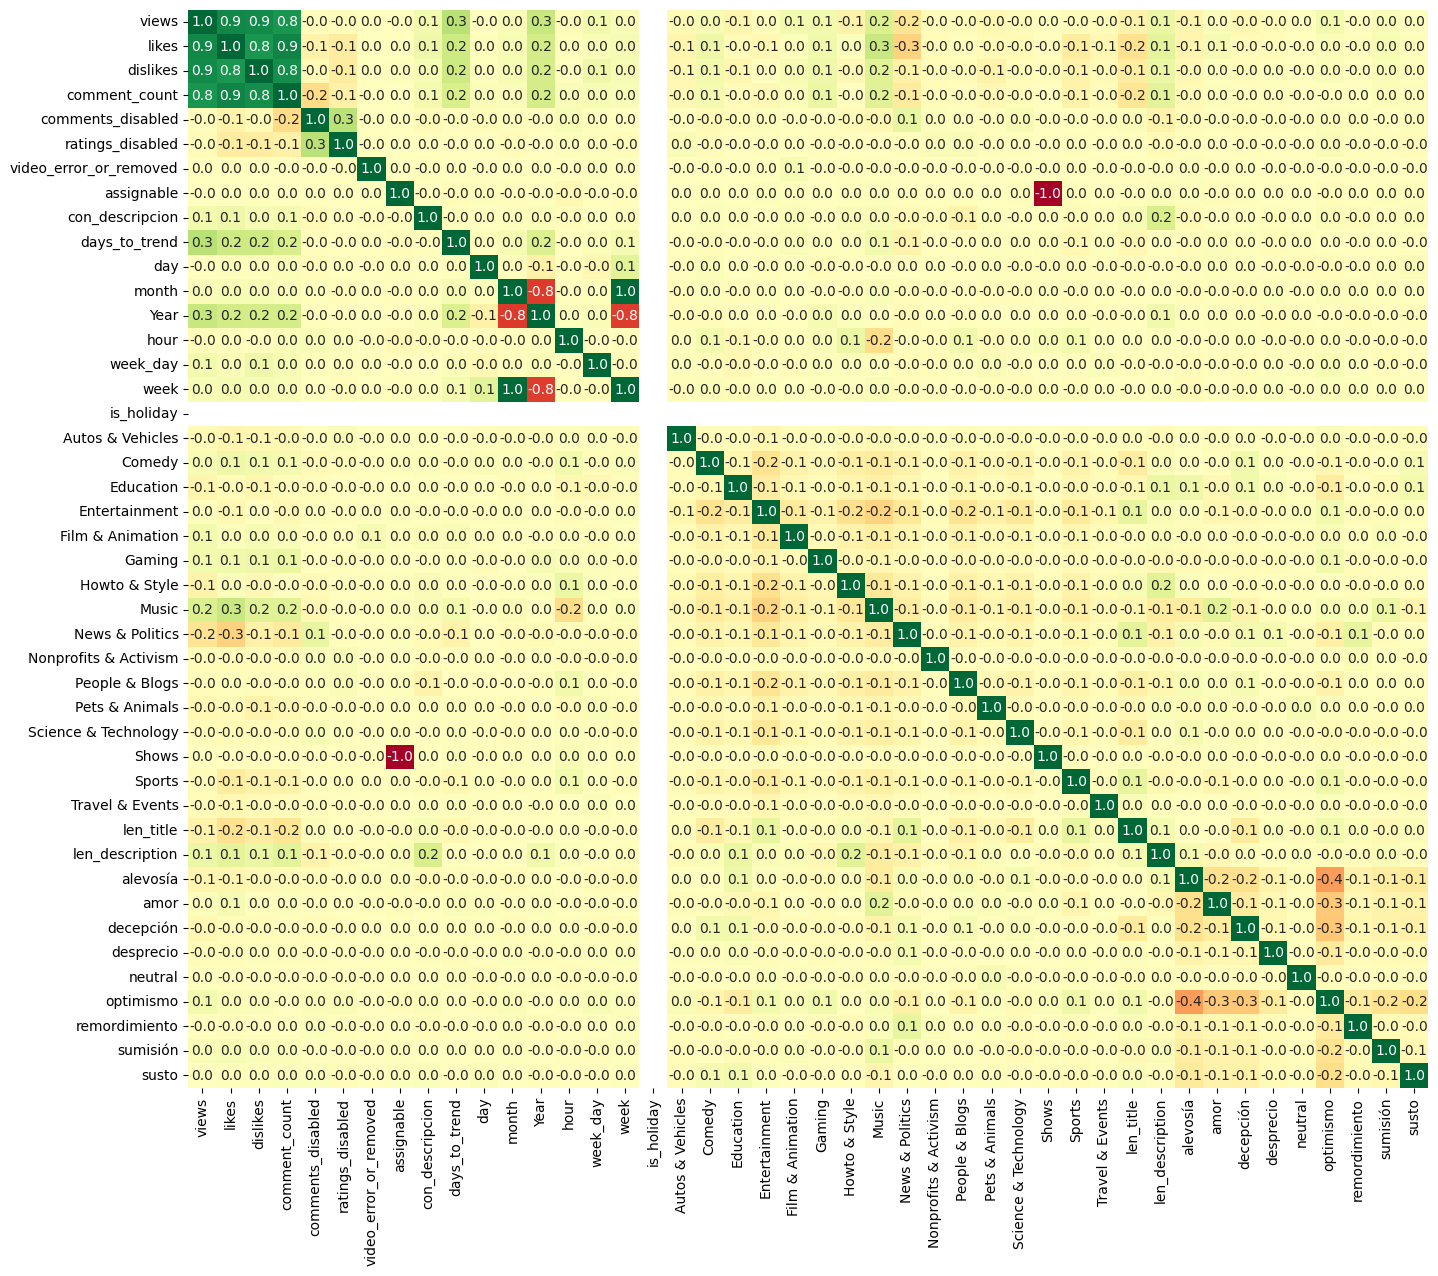

In [59]:
plt.figure(figsize=(16, 14))  
sns.heatmap(
    df.select_dtypes(include=['number']).corr(method='spearman'),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=False 
)
plt.show()

Podemos observar lo siguiente:

- `Correlacción con pearson`: Evalúa la fuerza y dirección de la relación lineal entre dos variables cuantitativas continuas. En este caso, las variables views, likes, dislikes y comment_count presentan una fuerte correlación entre sí, lo que indica que son variables con alto poder predictivo mutuo
 
- `Correlación con kendall`: Evalúa la concordancia entre dos variables ordinales o de rango, comparando la proporción de pares ordenados de manera coincidente o discordante. En este caso, las variables mencionadas anteriormente mantienen una correlación fuerte. Además, la variable days_to_trend muestra correlaciones débiles (≈ 0,2) con views, likes, dislikes y comment_count.

- `Correlación con spearman`: Evalúa la fuerza y dirección de una relación monótona entre dos variables, utilizando rangos en lugar de valores brutos. En este caso, se observa que la variable days_to_trend incrementa su correlación con views a un valor aproximado de 0,3.

En resumen, la variable `views` presenta una correlación muy fuerte (≥ 0.8) con `likes`, `dislikes` y `comment_count`, y esta relación se da de manera recíproca. Asimismo, se observan correlaciones positivas débiles (≈ 0.3) con las variables `days_to_trend`, el año de publicación del video y algunas categorías de videos. 

En cuanto a la variable que indica si un video entra en tendencia, se encuentran correlaciones débiles (≈ 0.3) con views, likes, dislikes, comment_count y el año de publicación. Esto sugiere que existen variables que influyen en el tiempo que tarda un video en volverse tendencia. En particular, el año de publicación muestra un efecto negativo significativo, con una correlación de Pearson de -0.7. Esto indica que los videos más antiguos tienden a tardar más en alcanzar la tendencia.

## Resumen

# Modelado